# neural_network_classification

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from time import time
import sklearn
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score 
from datetime import datetime
torch.manual_seed(0)

### Loading the Dataset

In [2]:
data_path = join(".", "data_local")
checkpoints = join(".", "logs", "checkpoints_nn_classification")

In [3]:
data = pd.read_csv(join(data_path, "final_dataset_pca.csv"))

# DROP 'canceled' PROJECTS
data = data[data['state'].isin(['successful', 'failed'])]

# Data Cleaning

In [4]:
# EXTRACTING INFORMATION ON CATEGORIES
def fun(j):
    return re.findall(r'\'(\b\w+\b)\'', j) + list(map(lambda x: x[0]+" " +x[1], re.findall(r"\"(\w+).*?(\w \w+)\"", j)))

data['category'] = data['category'].apply(fun)
data['sub_category'] = data['sub_category'].apply(fun)
data['category_2'] = data['category'].apply(lambda x: str(x[1]) if len(x)>1 else 'No category')
data['category'] = data['category'].apply(lambda x: str(x[0]) if len(x)>0 else 'No category')
data['sub_category'] = data['sub_category'].apply(lambda x: x[0] if len(x)>0 else 'No sub_category')


# EXTRACTING INFORMATION ON DURATION(in days) OF EACH PROJECT
data['deadline'] = data['deadline'].apply(lambda x: datetime.fromtimestamp(int(x)))
data['launched_at'] = data['launched_at'].apply(lambda x: datetime.fromtimestamp(int(x)))
data['duration'] = data['deadline']-data['launched_at']
data['duration'] =data['duration'].apply(lambda x: x.days)


# CONVERTING GOAL IN USD_GOAL
data['usd_goal'] = data['goal']*data['fx_rate']


# LABELING TARGET IN 0=FAILED and 1=SUCCESSFUL
data['state'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)


# DROP USLESS OR ALREADY USED COLUMNS AND REMOVE ALL OBSERVATION WITH Nan CAUSED BY ERROR 404 DURING SCRAPING
data_class = data.drop(columns=['id', 'project_url', 'image', 'goal', 'fx_rate', 'usd_pledged', 'launched_at', 'deadline'])
data_class = data_class.dropna(axis = 0, how ='any')


# BALANCING THE 2 CLASSES WILL IMPROVE THE RESULTS
majority_class = data_class[data_class['state']==1]
minority_class = data_class[data_class['state']==0]
balanced_class = majority_class.sample(n=94601, random_state=1) #94584
data_class = pd.concat([balanced_class, minority_class]) 

# Classification using NN

In [5]:
# SPLITTING TRAIN AND TEST SET
train_class_X, test_class_X, train_class_y, test_class_y =  train_test_split(data_class.drop(columns=['state']), 
                                                                             data_class['state'], test_size=20000,
                                                                             random_state=1)
print(f'lenght of train-set: {len(train_class_X)}')
print(f'lenght of test-set: {len(test_class_X)}')
# CATEGORICAL FEATURES (indices are needed for LIME and Catboost)
categorical_feat = ['category', 'country', 'sub_category',  'Launch_Week',
                    'Launch_Month', 'Deadline_Week', 'Deadline_Month',  'category_2',]

categorical_features = []
numeric_features = []
for col in categorical_feat:
    categorical_features.append(list(data_class.drop(columns=['state']).columns).index(col))

    
# NUMERIC FEATURES NEEDED TO APPLY STANDARD SCALER ONLY ON NUMERIC VARIABLES    
numeric_features = [col for i,col in enumerate(list(data_class.drop(columns=['state']).columns)) if col not in categorical_feat]


# LABELING OF CATEGORICAL FEATURES AND MAP(categorical_names) USED FOR LIME
arr = np.array(train_class_X)
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(np.array(data_class.drop(columns=['state']))[:, feature])
    train_class_X.iloc[:, feature] = le.transform(train_class_X.iloc[:, feature])
    test_class_X.iloc[:, feature] = le.transform(test_class_X.iloc[:, feature])
    categorical_names[feature] = le.classes_

for k, v in categorical_names.items():
    categorical_names[k] = list(arr[:, k])
    

# STANDARD SCALER 
num_cols = [col for col in train_class_X if col not in categorical_feat]
scaler = StandardScaler()
train_class_X = scaler.fit_transform(train_class_X)
test_class_X = scaler.transform(test_class_X)

lenght of train-set: 169185
lenght of test-set: 20000


In [6]:
train_x = np.array(train_class_X)
test_x = np.array(test_class_X)
train_y = np.array(train_class_y)
test_y = np.array(test_class_y)

In [7]:
test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=10000, random_state=1)

In [8]:
train_dataset = TensorDataset(torch.Tensor(train_x.astype("float32")), torch.Tensor(train_y.astype("float32")))
val_dataset = TensorDataset(torch.Tensor(val_x.astype("float32")), torch.Tensor(val_y.astype("float32")))
test_dataset = TensorDataset(torch.Tensor(test_x.astype("float32")), torch.Tensor(test_y.astype("float32")))

train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)

## Embedding Data

In [9]:
class DeepRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers=5):
        super(DeepRegressor, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.num_hidden_layers = n_hidden_layers


        self.first_layer = nn.Sequential(nn.Linear(self.input_size, self.hidden_size),
                                         nn.BatchNorm1d(self.hidden_size),
                                         nn.ReLU(),
                                         nn.Dropout(0.01))

        self.hidden_layers = nn.Sequential()
        for _ in range(self.num_hidden_layers):
            self.hidden_layers.add_module("linear", nn.Linear(self.hidden_size, self.hidden_size))
            self.hidden_layers.add_module("batch_norm", nn.BatchNorm1d(self.hidden_size))
            self.hidden_layers.add_module("activation", nn.ReLU())
            self.hidden_layers.add_module("dropout", nn.Dropout(0.01))

        self.last_layer1 = nn.Sequential(nn.Linear(self.hidden_size, int(self.hidden_size/2)),
                                         nn.BatchNorm1d(int(self.hidden_size/2)),
                                         nn.ReLU(),
                                         nn.Dropout(0.01))
        self.last_layer2 = nn.Linear(int(self.hidden_size/2), 1)

    def forward(self, x):
        hidden_state = self.first_layer(x)
        x = self.hidden_layers(hidden_state)
        x = self.last_layer1(x)
        output = self.last_layer2(x)
        return output.squeeze(1)

In [10]:
model = DeepRegressor(train_x.shape[1], 32, n_hidden_layers=4)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.002, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.5)

In [11]:
for param in model.parameters():
    param.requires_grad = True

epochs = 30
k_best_models = 4
loss_history = {"train": [], "val": []}
best_models_df = pd.DataFrame()

start_training = time()
for epoch in range(epochs):
    start_epoch = time()
    model.train()
    loss_history["train"].append(0)
    accuracy = 0
    for i, batch in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        optimizer.zero_grad()
        # Forward pass
        y_pred = model(inputs)
        # Compute Loss
        loss = criterion(y_pred, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        loss_history["train"][epoch] += loss.item()/len(train_dataloader)
        accuracy += ((y_pred > 0.5) == labels).sum()/labels.size(0)/len(train_dataloader)

    print(f"\n------> Epoch {epoch+1} <------\n    Train CossEntrpy loss: {loss_history['train'][epoch]}, Accuracy: {accuracy}")
    
    model.eval()
    loss_history["val"].append(0)
    accuracy = 0
    for i, batch in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        with torch.no_grad():
            y_pred = model(inputs)

        # forward + backward + optimize
        loss_history["val"][epoch] += criterion(y_pred, labels).item()/len(val_dataloader)
        accuracy += ((y_pred > 0.5) == labels).sum()/labels.size(0)/len(val_dataloader)

    print(f"    Val   CossEntrpy loss: {loss_history['val'][epoch]}, Accuracy: {accuracy}")

    # check for overfitting:
    early_stopping_steps = 5
    if len(loss_history["val"]) > 4 and \
            all(map(lambda x: x[0]<x[1], zip(loss_history["val"][-(early_stopping_steps)-1:-1], loss_history["val"][-(early_stopping_steps):]))) and \
            all(map(lambda x: x[0]>x[1], zip(loss_history["train"][-(early_stopping_steps)-1:-1], loss_history["train"][-(early_stopping_steps):]))):
        break

    best_models_df = best_models_df.append({"loss": loss_history["val"][epoch], "epoch": epoch, "state_dict": model.state_dict()}, ignore_index=True).sort_values("loss", ignore_index=True).head(k_best_models)

    scheduler.step()
    print(f"    Epoch time: {round((time()-start_epoch)//60)}m {round((time()-start_epoch)%60)}s")

print('\n\n****************** Finished Training ******************')
print(f"Time elapsed for training: {round((time()-start_training)//60)}:{round((time()-start_training)%60)}")


------> Epoch 1 <------
    Train CossEntrpy loss: 0.46929458390115375, Accuracy: 0.7632501721382141
    Val   CossEntrpy loss: 0.4493877413166556, Accuracy: 0.7588576078414917
    Epoch time: 0m 10s

------> Epoch 2 <------
    Train CossEntrpy loss: 0.4439946507045977, Accuracy: 0.778934121131897
    Val   CossEntrpy loss: 0.43042714485696926, Accuracy: 0.7806529402732849
    Epoch time: 0m 11s

------> Epoch 3 <------
    Train CossEntrpy loss: 0.43407491800824743, Accuracy: 0.7845840454101562
    Val   CossEntrpy loss: 0.4150199620587052, Accuracy: 0.791500985622406
    Epoch time: 0m 10s

------> Epoch 4 <------
    Train CossEntrpy loss: 0.4261673432119673, Accuracy: 0.7897783517837524
    Val   CossEntrpy loss: 0.41647140843093794, Accuracy: 0.7795579433441162
    Epoch time: 0m 10s

------> Epoch 5 <------
    Train CossEntrpy loss: 0.4222002637864246, Accuracy: 0.7918214797973633
    Val   CossEntrpy loss: 0.44279371818919105, Accuracy: 0.7525874972343445
    Epoch time: 0m 1

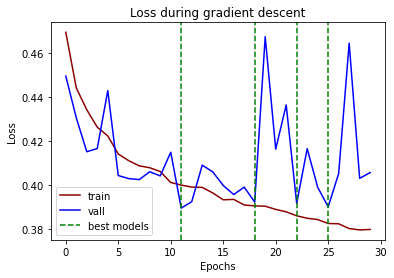

In [12]:
plt.title("Loss during gradient descent")
plt.plot(range(epochs), loss_history["train"], label="train", color="darkred")
plt.plot(range(epochs), loss_history["val"], label="vall", color="blue")
for i, best_epoch in best_models_df["epoch"].iteritems():
    plt.axvline(best_epoch, ls="--", label="best models" if i==0 else None, color="green")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## Testing the Best Models

In [13]:
model.eval()
test_accuracies = []
start_tests = time()
for index, (epoch, state_dict) in best_models_df[["epoch", "state_dict"]].iterrows():
    model.load_state_dict(state_dict)

    test_y_pred = []
    test_y_true = []
    start = time()
    for i, batch in enumerate(test_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        with torch.no_grad():
            outputs = model(inputs)

        test_y_pred.append(outputs)
        test_y_true.append(labels)

    test_y_pred = torch.cat(test_y_pred)
    test_y_true = torch.cat(test_y_true)
    loss = (criterion(test_y_pred, test_y_true).sqrt().mean(dim=0)).item()
    accuracy = ((test_y_pred > 0.5) == test_y_true).sum()/test_y_true.size(0)

    test_accuracies.append(accuracy.item())

    #print(f'------> Tested model {index}, saved at epoch {epoch} <------')
    #print(f"    Test   CossEntrpy loss: {loss}, Accuracy: {accuracy}")
    #print(f"    in {time()-start} seconds \n")

#print(f'\n****************** Finished Testing for all the models ******************')
#print(f"Time elapsed for testing: {round((time()-start_tests)//60)}:{round((time()-start_tests)%60)}")
best_models_df["test_acc"] = test_accuracies

In [14]:
best_models_df = best_models_df.sort_values(by="test_acc", ascending=False, ignore_index=True)
torch.save(best_models_df.loc[0, "state_dict"], join(checkpoints, f"model_with_acc_{str(best_models_df.loc[0, 'test_acc'])[2:7]}.pt"))
best_models_df.drop(columns="state_dict")

,epoch,loss,test_acc
0,11.0,0.389418,0.7855
1,25.0,0.389969,0.7855
2,22.0,0.391551,0.7855
3,18.0,0.392149,0.7855


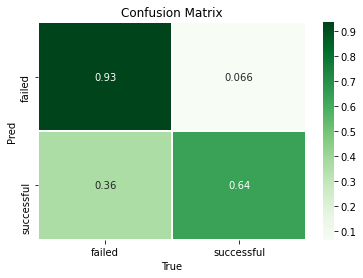

In [15]:
conf_mat = confusion_matrix(test_y_true, (test_y_pred.numpy() > 0.5)*1, normalize="true")
ax = sns.heatmap(conf_mat, linewidth=0.5, xticklabels=['failed', 'successful'], yticklabels=['failed', 'successful'], cmap='Greens', annot=True)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Pred")
plt.show()